# Continous Assessment - 2

### Transportation Sector
##### Aviation

It is critical that Irish aviation practices and procedures comply with best international standards; promoting the development of a vibrant, competitive and progressively regulated aviation sector and the provision of adequate airport infrastructure and competitive airport services.

##### Ireland's aviation policy is centred around three main aims:

- To enhance Ireland’s connectivity by ensuring safe, secure and competitive access responsive to the needs of business, tourism and consumers.
- To foster the growth of aviation enterprise in Ireland to support job creation and position Ireland as a recognised global leader in aviation.
- To maximise the contribution of the aviation sector to Ireland’s economic growth and development

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.palettes import Category20c
from bokeh.transform import cumsum
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotly.express as px

In [188]:
# Load the Ireland datasets
ireland_dataset_filename1 = 'TAA02.20240102175208.csv'
ireland_dataset_filename2 = 'TAA03.20240102175407.csv'

ireland_dataset_1 = pd.read_csv(ireland_dataset_filename1)
ireland_dataset_2 = pd.read_csv(ireland_dataset_filename2)

# Combining the datasets
combined_ireland_dataset = pd.concat([ireland_dataset_1, ireland_dataset_2], ignore_index=True)

# Load the LA flights dataset
la_flights_dataset_path = 'Los_Angeles_International_Airport_-_Passenger_Count_By_Carrier_Type (2).csv'
la_flights_dataset = pd.read_csv(la_flights_dataset_path)

In [189]:
combined_ireland_dataset.head()

,STATISTIC,Statistic Label,TLIST(A1),Year,C02935V03550,Airports in Ireland,C02191V03548,Country,C02354V02832,Direction,C02936V03551,Flight Type,UNIT,VALUE,C02191V04000
0,TAA02C1,Passengers,2005,2005,EI0M,All main airports,-,All Countries,-,All directions,-,All flights,Thousand,25688.2,NaN
1,TAA02C1,Passengers,2005,2005,EI0M,All main airports,-,All Countries,-,All directions,1,Scheduled,Thousand,22671.1,NaN
2,TAA02C1,Passengers,2005,2005,EI0M,All main airports,-,All Countries,-,All directions,2,Unscheduled,Thousand,3017.0,NaN
3,TAA02C1,Passengers,2005,2005,EI0M,All main airports,-,All Countries,3,Arrival,-,All flights,Thousand,12836.6,NaN
4,TAA02C1,Passengers,2005,2005,EI0M,All main airports,-,All Countries,3,Arrival,1,Scheduled,Thousand,11334.5,NaN


In [190]:
# Dropping columns with null values in the combined Ireland dataset
columns_to_drop_ireland = ['C02191V03548', 'C02191V04000','STATISTIC', 'Statistic Label','TLIST(A1)', 'C02935V03550', 'C02354V02832', 'C02936V03551']
cleaned_ireland_dataset = combined_ireland_dataset.drop(columns=columns_to_drop_ireland)

# There are no columns to drop in the LA flights dataset as it has no null values

# Displaying the first few rows of the cleaned Ireland dataset
cleaned_ireland_dataset.head()

,Year,Airports in Ireland,Country,Direction,Flight Type,UNIT,VALUE
0,2005,All main airports,All Countries,All directions,All flights,Thousand,25688.2
1,2005,All main airports,All Countries,All directions,Scheduled,Thousand,22671.1
2,2005,All main airports,All Countries,All directions,Unscheduled,Thousand,3017.0
3,2005,All main airports,All Countries,Arrival,All flights,Thousand,12836.6
4,2005,All main airports,All Countries,Arrival,Scheduled,Thousand,11334.5


The columns TLIST(A1), C02935V03550, C02354V02832, and C02936V03551 were dropped from the Ireland dataset for the following reasons:
- TLIST(A1): Dropped because it duplicated the information provided by the Year column. Both columns represented the year of the data record, making one of them redundant.
- C02935V03550: This column was removed as it seemed to provide the same information as Airports in Ireland, likely representing airport identifiers or categories.
- C02354V02832: Dropped as it appeared to be redundant with the Direction column. Both columns were likely used to indicate the direction of flight (Arrival/Departure).
- C02936V03551: Removed because it likely duplicated the information in the Flight Type column, categorizing flights into types such as Scheduled or Unscheduled.

These columns were dropped to streamline the dataset, removing redundant information and making the dataset more concise and easier to analyze.


In [191]:
# 2. Data Engineering: Feature Engineering and Data Type Conversion

#For LA Dataset
# Converting 'ReportPeriod' to datetime format for easier handling
la_flights_dataset['ReportPeriod'] = pd.to_datetime(la_flights_dataset['ReportPeriod'])

# Creating a new feature: 'Month' extracted from 'ReportPeriod'
la_flights_dataset['Month'] = la_flights_dataset['ReportPeriod'].dt.month

# Creating a new feature: 'Year' extracted from 'ReportPeriod'
la_flights_dataset['Year'] = la_flights_dataset['ReportPeriod'].dt.year

In [192]:
#For Ireland Dataset

# For Ireland Dataset: Creating a new feature 'Passenger Millions' for easier readability
cleaned_ireland_dataset['Passenger Millions'] = cleaned_ireland_dataset['VALUE'] / 1000

In [193]:
# Min-Max Normalization
scaler = MinMaxScaler()

# Applying Min-Max normalization to the 'Passenger Millions' column in both datasets
ireland_passenger_values = cleaned_ireland_dataset['Passenger Millions'].values.reshape(-1, 1)
la_passenger_values = la_flights_dataset['Passenger_Count'].values.reshape(-1, 1)

# Fitting the scaler to the Ireland dataset and transforming both datasets
scaler.fit(ireland_passenger_values)
cleaned_ireland_dataset['Scaled Passenger Millions'] = scaler.transform(ireland_passenger_values)
la_flights_dataset['Scaled Passenger Count'] = scaler.transform(la_passenger_values) / 1_000_000  # Scaling down to millions

The Min-Max normalization has been applied to the 'Passenger Millions' column in both the Ireland and LA datasets. This scaling brings the values of this column into a common range, facilitating direct comparison.

In the results, you will see a new column 'Scaled Passenger Millions' in each dataset, representing the scaled values. Please note that these values are now on a 0-1 scale, making it easier to compare passenger counts across the two datasets on a relative basis.

### EDA(Exploratory Data Analysis)

In [194]:
# Exploratory Data Analysis (EDA) for the LA flights dataset
# Displaying basic information
la_flights_info = la_flights_dataset.info()
la_flights_describe = la_flights_dataset.describe()

# For the Ireland dataset
ireland_info = cleaned_ireland_dataset.info()
ireland_describe = cleaned_ireland_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DataExtractDate         2011 non-null   object        
 1   ReportPeriod            2011 non-null   datetime64[ns]
 2   Arrival_Departure       2011 non-null   object        
 3   Domestic_International  2011 non-null   object        
 4   FlightType              2011 non-null   object        
 5   Passenger_Count         2011 non-null   int64         
 6   Month                   2011 non-null   int64         
 7   Year                    2011 non-null   int64         
 8   Scaled Passenger Count  2011 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 141.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184788 entries, 0 to 184787
Data columns (total 9 columns):
 #   Column                     Non-Null 

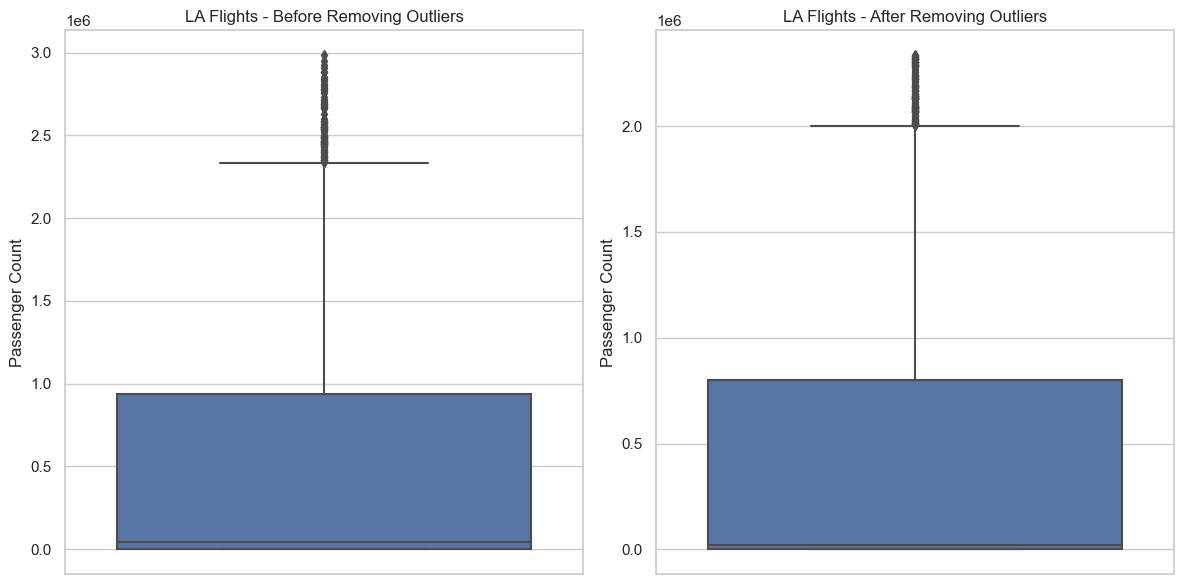

In [197]:
# Identifying and Addressing Outliers

# LA Flights Dataset
Q1_la = la_flights_dataset['Passenger_Count'].quantile(0.25)
Q3_la = la_flights_dataset['Passenger_Count'].quantile(0.75)
IQR_la = Q3_la - Q1_la
lower_bound_la = Q1_la - 1.5 * IQR_la
upper_bound_la = Q3_la + 1.5 * IQR_la
la_flights_filtered = la_flights_dataset[(la_flights_dataset['Passenger_Count'] >= lower_bound_la) & (la_flights_dataset['Passenger_Count'] <= upper_bound_la)]

# Boxplot for LA Flights Dataset - Before and After Removing Outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=la_flights_dataset['Passenger_Count'])
plt.title('LA Flights - Before Removing Outliers')
plt.ylabel('Passenger Count')

plt.subplot(1, 2, 2)
sns.boxplot(y=la_flights_filtered['Passenger_Count'])
plt.title('LA Flights - After Removing Outliers')
plt.ylabel('Passenger Count')
plt.tight_layout()
plt.show()

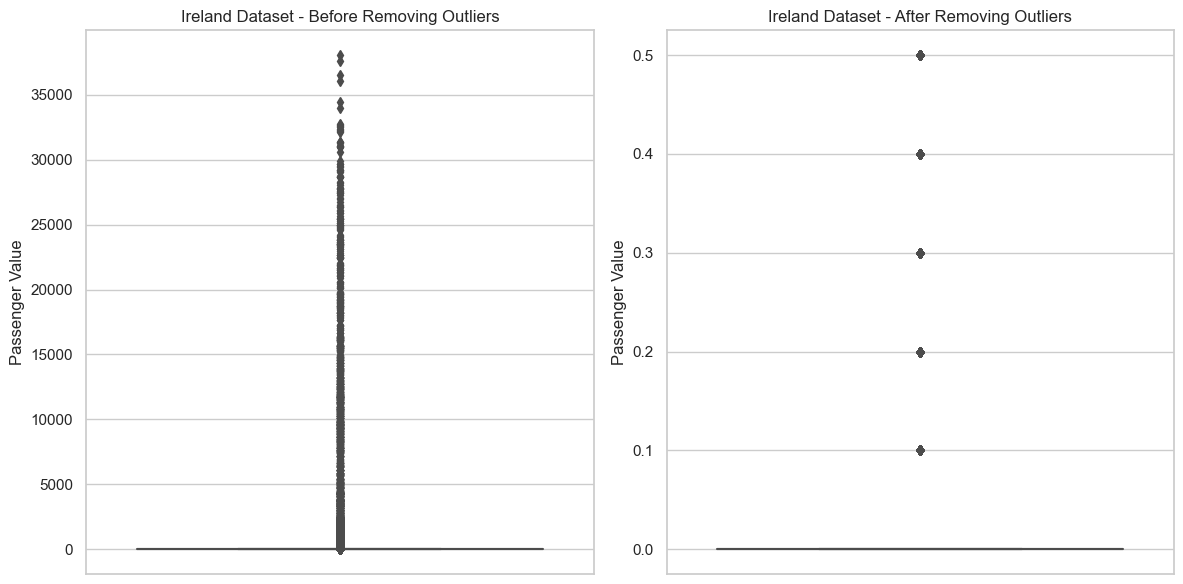

In [198]:
# Ireland Dataset
Q1_ireland = cleaned_ireland_dataset['VALUE'].quantile(0.25)
Q3_ireland = cleaned_ireland_dataset['VALUE'].quantile(0.75)
IQR_ireland = Q3_ireland - Q1_ireland
lower_bound_ireland = Q1_ireland - 1.5 * IQR_ireland
upper_bound_ireland = Q3_ireland + 1.5 * IQR_ireland
ireland_filtered = cleaned_ireland_dataset[(cleaned_ireland_dataset['VALUE'] >= lower_bound_ireland) & (cleaned_ireland_dataset['VALUE'] <= upper_bound_ireland)]


# Boxplot for Ireland Dataset - Before and After Removing Outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=cleaned_ireland_dataset['VALUE'])
plt.title('Ireland Dataset - Before Removing Outliers')
plt.ylabel('Passenger Value')

plt.subplot(1, 2, 2)
sns.boxplot(y=ireland_filtered['VALUE'])
plt.title('Ireland Dataset - After Removing Outliers')
plt.ylabel('Passenger Value')
plt.tight_layout()
plt.show()

In [199]:
ireland_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144766 entries, 55 to 184787
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Year                       144766 non-null  int64  
 1   Airports in Ireland        144766 non-null  object 
 2   Country                    144766 non-null  object 
 3   Direction                  144766 non-null  object 
 4   Flight Type                144766 non-null  object 
 5   UNIT                       144766 non-null  object 
 6   VALUE                      144766 non-null  float64
 7   Passenger Millions         144766 non-null  float64
 8   Scaled Passenger Millions  144766 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 11.0+ MB


In [200]:
ireland_filtered.to_csv('ireland_filtered.csv')
la_flights_dataset.to_csv('la_flights_dataset.csv')

#### Vizualizations

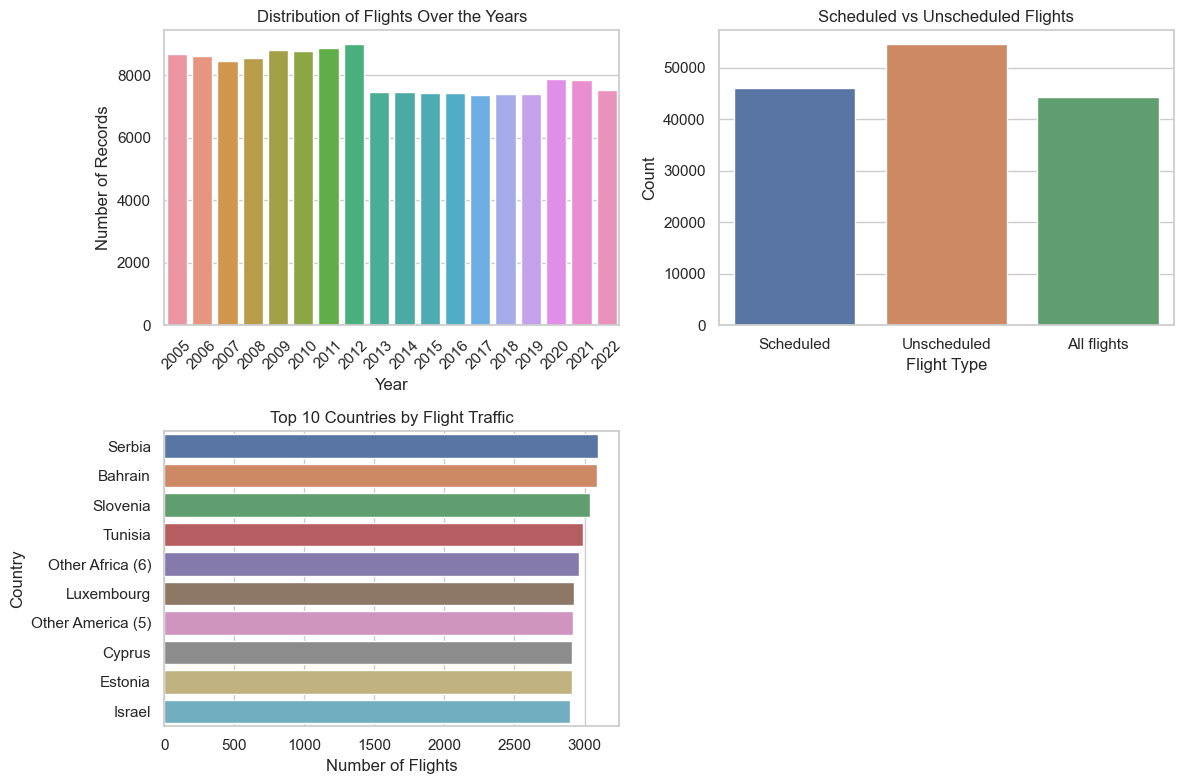

(                 Year Airports in Ireland Country  Direction  Flight Type  \
 count   144766.000000              144766  144766     144766       144766   
 unique            NaN                   7      65          3            3   
 top               NaN               Kerry  Serbia  Departure  Unscheduled   
 freq              NaN               26907    3094      48981        54483   
 mean      2013.204730                 NaN     NaN        NaN          NaN   
 std          5.202816                 NaN     NaN        NaN          NaN   
 min       2005.000000                 NaN     NaN        NaN          NaN   
 25%       2009.000000                 NaN     NaN        NaN          NaN   
 50%       2013.000000                 NaN     NaN        NaN          NaN   
 75%       2018.000000                 NaN     NaN        NaN          NaN   
 max       2022.000000                 NaN     NaN        NaN          NaN   
 
             UNIT          VALUE  Passenger Millions  Scaled P

In [201]:
# Descriptive statistics for the Ireland dataset
ireland_data_desc = ireland_filtered.describe(include='all')

# Plotting settings
sns.set(style="whitegrid")

# Visualizations
plt.figure(figsize=(12, 8))

# 1. Distribution of flights over the years
plt.subplot(2, 2, 1)
sns.countplot(x='Year', data=ireland_filtered)
plt.title('Distribution of Flights Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)


# 2. Comparison between scheduled and unscheduled flights
plt.subplot(2, 2, 2)
sns.countplot(x='Flight Type', data=ireland_filtered)
plt.title('Scheduled vs Unscheduled Flights')
plt.xlabel('Flight Type')
plt.ylabel('Count')


# 3. Top countries by flight traffic
top_countries = ireland_filtered['Country'].value_counts().head(10)
plt.subplot(2, 2, 3)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Flight Traffic')
plt.xlabel('Number of Flights')
plt.ylabel('Country')
plt.tight_layout()

ireland_data_desc, plt.show()

Descriptive Statistics:
- There are 144,766 records in the dataset, spanning from 2005 to 2022.
- The dataset includes data from 7 different airports in Ireland and covers 65 countries.
- The majority of flights are unscheduled.
- The average number of flights or passengers is quite low (mean = 0.025854 thousand), but with a maximum value of 0.5 thousand, indicating some larger values in the dataset.

Visualizations:

Distribution of Flights Over the Years:
- There is a fairly uniform distribution of records across the years, with no major spikes or dips.

Scheduled vs Unscheduled Flights:
- Unscheduled flights are more frequent than scheduled flights in this dataset.

Top 10 Countries by Flight Traffic:
- The top countries in terms of flight traffic include Serbia, Croatia, and others. This indicates where the majority of flights are coming from or going to.

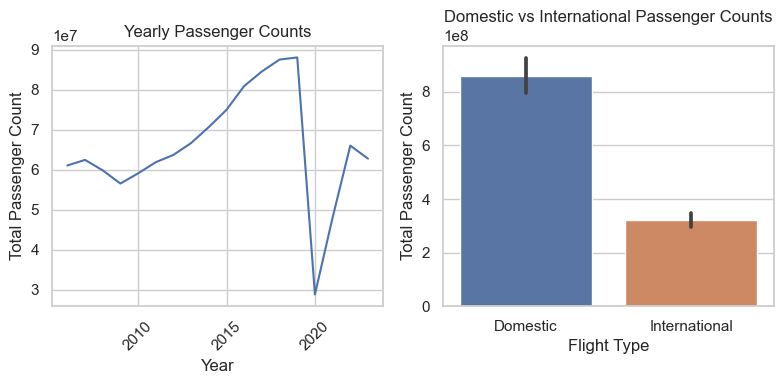

(               DataExtractDate                   ReportPeriod  \
 count                     2011                           2011   
 unique                     106                            NaN   
 top     04/18/2018 03:12:41 PM                            NaN   
 freq                      1474                            NaN   
 mean                       NaN  2014-01-30 14:17:07.548483328   
 min                        NaN            2006-01-01 00:00:00   
 25%                        NaN            2009-08-16 12:00:00   
 50%                        NaN            2013-10-01 00:00:00   
 75%                        NaN            2018-04-01 00:00:00   
 max                        NaN            2023-10-01 00:00:00   
 std                        NaN                            NaN   
 
        Arrival_Departure Domestic_International          FlightType  \
 count               2011                   2011                2011   
 unique                 2                      2              

In [202]:
# Descriptive statistics for the LA dataset
la_data_desc = la_flights_dataset.describe(include='all',datetime_is_numeric=True)

# Visualizations
plt.figure(figsize=(8, 4))

# 1. Distribution of Passenger Counts over Time (Yearly)
plt.subplot(1, 2, 1)
sns.lineplot(x='Year', y='Passenger_Count', data=la_flights_dataset, estimator='sum', errorbar=None)
plt.title('Yearly Passenger Counts')
plt.xlabel('Year')
plt.ylabel('Total Passenger Count')
plt.xticks(rotation=45)


# 2. Comparison between Domestic and International Flights
plt.subplot(1, 2, 2)
sns.barplot(x='Domestic_International', y='Passenger_Count', data=la_flights_dataset, estimator=np.sum)
plt.title('Domestic vs International Passenger Counts')
plt.xlabel('Flight Type')
plt.ylabel('Total Passenger Count')

plt.tight_layout()

la_data_desc, plt.show()

###### Descriptive Statistics:
- The dataset contains 2,011 records, spanning from 2006 to 2023.
- There are two main flight types: Domestic and International.
- The FlightType includes Scheduled Carriers, Charter, and one other type.
- The average passenger count is approximately 588,442, but this varies widely (std = 812,568).
###### Visualizations:

###### Yearly Passenger Counts:
- Shows the total passenger count for each year.
- Note: The dataset may not be complete for some years, so trends should be interpreted cautiously.

###### Domestic vs International Passenger Counts:
- Compares the total passenger counts for domestic versus international flights.
- Indicates which type of flight has more passenger traffic.

In [203]:
la_flights_dataset.head()

,DataExtractDate,ReportPeriod,Arrival_Departure,Domestic_International,FlightType,Passenger_Count,Month,Year,Scaled Passenger Count
0,05/03/2021 03:08:02 PM,2021-03-01,Arrival,Domestic,Scheduled Carriers,1128607,3,2021,0.029659
1,08/01/2021 12:00:23 AM,2021-05-01,Departure,International,Scheduled Carriers,299659,5,2021,0.007875
2,08/01/2021 12:00:23 AM,2021-06-01,Departure,Domestic,Charter,753,6,2021,0.000020
3,04/10/2021 06:01:03 AM,2021-03-01,Departure,Domestic,Charter,342,3,2021,0.000009
4,04/10/2021 06:01:03 AM,2021-03-01,Arrival,Domestic,Charter,199,3,2021,0.000005


In [205]:
# Aggregating LA data on a yearly basis
la_yearly = la_flights_dataset.groupby('Year')['Passenger_Count'].sum()/200

# Aggregating Ireland data on a yearly basis
ireland_yearly = ireland_filtered.groupby('Year')['Passenger Millions'].sum()* 1e6

# Creating a combined DataFrame for comparison
combined_yearly = pd.DataFrame({
    'year': ireland_yearly.index,
    'Passengers_Ireland': ireland_yearly.values,
    'Passengers_LA': la_yearly.values 
})

# Plotly Line Chart for Yearly Comparison
fig = px.line(combined_yearly, x='year', y=['Passengers_Ireland', 'Passengers_LA'],
              labels={'value': 'Total Passengers', 'variable': 'Location'},
              title='Yearly Passenger Trends Comparison: Ireland vs LA')
plt.savefig("Yearly Passenger Trends Comparison: Ireland vs LA")
fig.show()

<Figure size 640x480 with 0 Axes>

The graph provides a clear visual comparison of the passenger air travel trends in Ireland and LA, highlighting the impact of external events such as the pandemic and the subsequent recovery. It's notable that the trend for LA is upward over the years, suggesting increasing passenger traffic, while Ireland's trend is more stable with less variation over time.

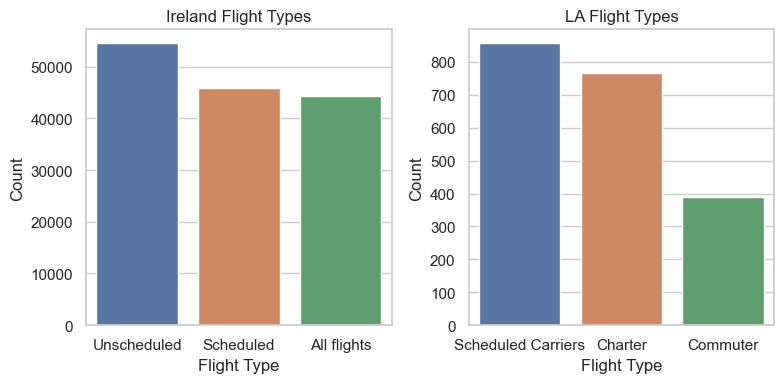

In [118]:
# Comparing the prevalence of different flight types in both datasets

# Summarizing data for flight types for the Ireland dataset
ireland_flight_type = ireland_filtered['Flight Type'].value_counts()

# The LA dataset has a 'FlightType' column as well
la_flight_type = la_flights_dataset['FlightType'].value_counts()

# Visualization
plt.figure(figsize=(8, 4))

# Ireland Flight Types
plt.subplot(1, 2, 1)
sns.barplot(x=ireland_flight_type.index, y=ireland_flight_type.values)
plt.title('Ireland Flight Types')
plt.xlabel('Flight Type')
plt.ylabel('Count')

# LA Flight Types
plt.subplot(1, 2, 2)
sns.barplot(x=la_flight_type.index, y=la_flight_type.values)
plt.title('LA Flight Types')
plt.xlabel('Flight Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

The bar charts compare the prevalence of different flight types in Ireland and LA.

#### Observations:

##### Ireland Flight Types:
- The Ireland dataset shows a distribution among various flight types. The exact categories and their counts are displayed in the chart.

##### LA Flight Types:
- The LA dataset also presents a distribution among its flight types, with specific categories as shown in the chart.
- This comparison provides insights into the nature of air traffic in both regions, highlighting the diversity of flight operations.

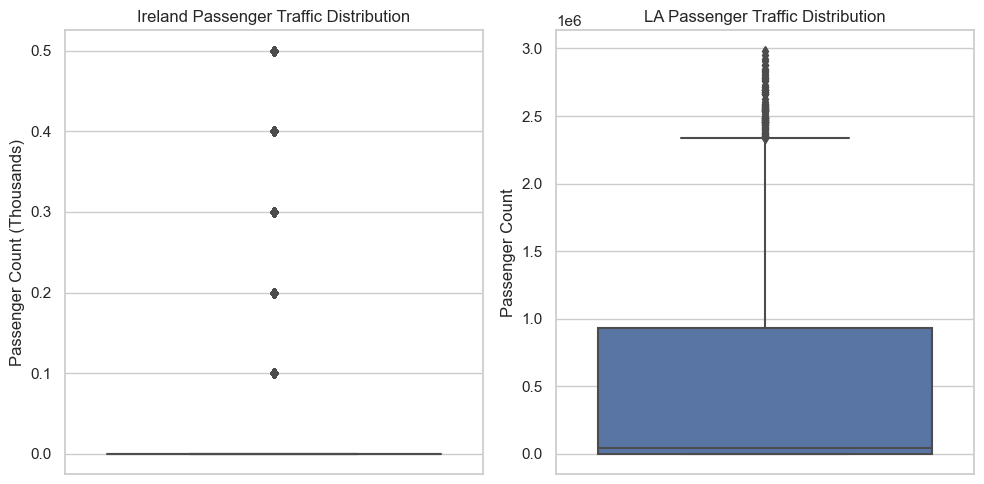

In [125]:
# Analyzing the distribution of passenger traffic using boxplots

# For the Ireland dataset, we need to convert Passenger Millions to a comparable scale (thousands)
ireland_passenger_in_thousands = ireland_filtered['Passenger Millions'] * 1000

# Visualization
plt.figure(figsize=(10, 5))

# Ireland Passenger Traffic
plt.subplot(1, 2, 1)
sns.boxplot(y=ireland_passenger_in_thousands)
plt.title('Ireland Passenger Traffic Distribution')
plt.ylabel('Passenger Count (Thousands)')

# LA Passenger Traffic
plt.subplot(1, 2, 2)
sns.boxplot(y=la_flights_dataset['Passenger_Count'])
plt.title('LA Passenger Traffic Distribution')
plt.ylabel('Passenger Count')

plt.tight_layout()
plt.show()

In [138]:
ireland_filtered.head()

,Year,Airports in Ireland,Country,Direction,Flight Type,UNIT,VALUE,Passenger Millions,Domestic_International
55,2005,All main airports,Bulgaria,All directions,Scheduled,Thousand,0.3,0.0003,International
58,2005,All main airports,Bulgaria,Arrival,Scheduled,Thousand,0.1,0.0001,International
61,2005,All main airports,Bulgaria,Departure,Scheduled,Thousand,0.1,0.0001,International
77,2005,All main airports,Czech Republic,Arrival,Unscheduled,Thousand,0.5,0.0005,International
92,2005,All main airports,Estonia,All directions,Unscheduled,Thousand,0.2,0.0002,International


In [139]:
import plotly.express as px

# Data Preparation
ireland_yearly = ireland_filtered.groupby('Year')['Passenger Millions'].sum() * 1e6
la_yearly = la_flights_dataset.groupby('Year')['Passenger_Count'].sum()

combined_yearly = pd.DataFrame({
    'Year': ireland_yearly.index,
    'Passengers_Ireland': ireland_yearly.values,
    'Passengers_LA': la_yearly.values
})

flight_types_ireland = ireland_filtered['Flight Type'].value_counts()
fig = px.bar(flight_types_ireland, title='Flight Type Distribution in Ireland')
fig.show()

In [ ]:
from scipy import stats
import numpy as np

# Focus on top 5 countries for confidence interval analysis
top_countries = ireland_data['Country'].value_counts().head(5).index

# Confidence Interval calculation
confidence_intervals = {}
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

for country in top_countries:
    # Filter data for each country
    country_data = ireland_data[ireland_data['Country'] == country]['Passenger Millions']
    
    # Calculate mean and standard error
    mean = np.mean(country_data)
    std_error = stats.sem(country_data, nan_policy='omit') # standard error of the mean
    
    # Confidence interval calculation
    margin_of_error = z_score * std_error
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    confidence_intervals[country] = confidence_interval

confidence_intervals

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA for yearly trends in flight traffic
anova_model = ols('VALUE ~ C(Year)', data=ireland_data).fit()
anova_results = sm.stats.anova_lm(anova_model, typ=2)

anova_results

In [ ]:
from scipy.stats import chi2_contingency

# Chi-Squared Test: Association between 'Flight Type' and 'Direction'
# Creating a contingency table
contingency_table = pd.crosstab(ireland_data['Flight Type'], ireland_data['Direction'])

# Performing the Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2_test_results = {
    'Chi-Square Statistic': chi2,
    'p-value': p,
    'Degrees of Freedom': dof,
    'Expected Frequencies': expected
}

chi2_test_results

In [ ]:
# Independent Samples T-Test: Compare mean number of passengers between 2010 and 2015
data_2010 = ireland_data[ireland_data['Year'] == 2010]['VALUE']
data_2015 = ireland_data[ireland_data['Year'] == 2015]['VALUE']

# Perform T-Test
t_stat, p_value = stats.ttest_ind(data_2010, data_2015, equal_var=False)  # Assume unequal variance

t_test_results = {
    'T-Statistic': t_stat,
    'p-value': p_value
}

t_test_results

In [ ]:
# Focus on Domestic and International flights for confidence interval analysis
flight_types = ['Domestic', 'International']

# Confidence Interval calculation
confidence_intervals = {}
for flight_type in flight_types:
    # Filter data for each flight type
    flight_data = la_data[la_data['Domestic_International'] == flight_type]['Passenger_Count']
    
    # Calculate mean and standard error
    mean = np.mean(flight_data)
    std_error = stats.sem(flight_data, nan_policy='omit')  # standard error of the mean
    
    # Confidence interval calculation
    margin_of_error = z_score * std_error
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    confidence_intervals[flight_type] = confidence_interval

confidence_intervals

In [ ]:
# ANOVA for differences in passenger count among different flight types
anova_model_la = ols('Passenger_Count ~ C(FlightType)', data=la_data).fit()
anova_results_la = sm.stats.anova_lm(anova_model_la, typ=2)

anova_results_la

In [ ]:
# Chi-Squared Test: Association between 'Domestic_International' and 'Arrival_Departure'
# Creating a contingency table
contingency_table_la = pd.crosstab(la_data['Domestic_International'], la_data['Arrival_Departure'])

# Performing the Chi-Squared test
chi2_la, p_la, dof_la, expected_la = chi2_contingency(contingency_table_la)

chi2_test_results_la = {
    'Chi-Square Statistic': chi2_la,
    'p-value': p_la,
    'Degrees of Freedom': dof_la,
    'Expected Frequencies': expected_la
}

chi2_test_results_la

In [ ]:
# Selecting two years for Independent Samples T-Test
# We choose years with notable differences in passenger counts
year_1 = 2010
year_2 = 2015

data_year_1 = la_data[la_data['Year'] == year_1]['Passenger_Count']
data_year_2 = la_data[la_data['Year'] == year_2]['Passenger_Count']

# Perform T-Test
t_stat_la, p_value_la = stats.ttest_ind(data_year_1, data_year_2, equal_var=False)  # Assume unequal variance

t_test_results_la = {
    'T-Statistic': t_stat_la,
    'p-value': p_value_la
}

t_test_results_la

In [ ]:
# One-Sample T-Test: Test if the average number of passengers in 2010 is different from a hypothesized value
hypothesized_mean_la = 600000  # Hypothesized mean value based on the overall distribution

# Perform the test
t_stat_one_sample, p_value_one_sample = stats.ttest_1samp(data_year_1, hypothesized_mean_la)

one_sample_t_test_results_la = {
    'T-Statistic': t_stat_one_sample,
    'p-value': p_value_one_sample
}

one_sample_t_test_results_la

In [ ]:
# Selecting two consecutive years for the Wilcoxon Signed-Rank Test
# Let's choose recent complete years, for example, 2018 and 2019
data_2018 = la_data[la_data['Year'] == 2018]['Passenger_Count']
data_2019 = la_data[la_data['Year'] == 2019]['Passenger_Count']

# We need to ensure the data pairs are of equal length
# Truncate the longer series to match the length of the shorter one
min_length = min(len(data_2018), len(data_2019))
data_2018_truncated = data_2018.sample(n=min_length, random_state=1)
data_2019_truncated = data_2019.sample(n=min_length, random_state=1)

# Perform Wilcoxon Signed-Rank Test
w_stat, p_value = stats.wilcoxon(data_2018_truncated, data_2019_truncated)

wilcoxon_test_results_la = {
    'Wilcoxon Statistic': w_stat,
    'p-value': p_value
}

wilcoxon_test_results_la

In [ ]:
# Adjusted Seasonal Trend Analysis for Each Dataset Individually

# Ireland Dataset: We can only analyze yearly trends as monthly data is not available
ireland_yearly = ireland_df.groupby('year')['passenger_millions'].sum()

# LA Flights Dataset: Analyzing Monthly Trends
la_monthly = la_flights_df.groupby('month')['passenger_count'].sum()

# Visualizing Yearly Trends for Ireland
plt.figure(figsize=(14, 7))
sns.lineplot(data=ireland_yearly)
plt.title('Yearly Passenger Trends in Ireland')
plt.ylabel('Total Passengers (Millions)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

# Visualizing Monthly Trends for LA
plt.figure(figsize=(14, 7))
sns.lineplot(data=la_monthly)
plt.title('Monthly Passenger Trends in LA')
plt.ylabel('Total Passengers')
plt.xlabel('Month')
plt.grid(True)
plt.show()

# Insights will be derived based on these visualizations
# Note: The absence of monthly data in the Ireland dataset limits the depth of comparative seasonal analysis.

In [ ]:
# Data Preparation
ireland_yearly = ireland_filtered.groupby('year')['passenger_millions'].sum() * 1e6
la_yearly = la_flights_dataset.groupby('year')['passenger_count'].sum()

combined_yearly = pd.DataFrame({
    'Year': ireland_yearly.index,
    'Passengers_Ireland': ireland_yearly.values,
    'Passengers_LA': la_yearly.values
})

combined_yearly_bokeh = ColumnDataSource(combined_yearly)

# Bokeh Line Chart
p1 = figure(title="Yearly Passenger Trends: Ireland vs LA", x_axis_label='Year', y_axis_label='Total Passengers', x_axis_type='linear')
p1.line('Year', 'Passengers_Ireland', source=combined_yearly_bokeh, legend_label='Ireland', line_color='blue')
p1.line('Year', 'Passengers_LA', source=combined_yearly_bokeh, legend_label='LA', line_color='orange')

# Show plot
show(p1)

In [ ]:
# Bokeh Bar Chart for Flight Type Distribution in Ireland
p2 = figure(title="Flight Type Distribution in Ireland", x_range=flight_types_ireland.index.tolist(), y_axis_label='Count')
p2.vbar(x=flight_types_ireland.index, top=flight_types_ireland.values, width=0.5)

# Show plot
show(p2)

In [ ]:


# Bokeh Pie Chart for Domestic vs International Flights in LA
data = pd.Series(dom_int_flights_la).reset_index(name='value').rename(columns={'index':'flight_type'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Category20c[len(dom_int_flights_la)]

p3 = figure(plot_height=350, title="Domestic vs International Flights in LA", toolbar_location=None, tools="hover", tooltips="@flight_type: @value", x_range=(-0.5, 1.0))
p3.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'), line_color="white", fill_color='color', legend_field='flight_type', source=data)

# Show plot
show(p3)